![Astrofisica Computacional](../logo.PNG)

---
## 01. Gravitational Waves Signal


Eduard Larrañaga (ealarranaga@unal.edu.co)

---


### About this notebook

In this notebook we present the method to In this notebook we will read and visualize one of the gravitational waves signal detected by LIGO.define a straight line that fits a dataset.

---

## Obtaining the Gravitational Wave signal

This notebook will show how to have a quick look at short segments of data from the [Gravitational Wave Open Science Center](https://www.gw-openscience.org)


The first step is to set the GPS time (t0) of the signal and chose the detector.

These are som examples of known signals:

- t0 = 1126259462.4    # -- GW150914
- t0 = 1187008882.4    # -- GW170817
- t0 = 933200215       # -- Loud hardware injection
- t0 = 1132401286.33   # -- Koi Fish Glitch

The detectors are:

- H1 : Handford
- L1 : Livingstone
- V1 : VIRGO

Complete information about events is available at [https://www.gw-openscience.org/eventapi/](https://www.gw-openscience.org/eventapi/)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


import requests, os
from gwpy.timeseries import TimeSeries
from gwosc.locate import get_urls


# -- Set a GPS time:
t0 = 1126259462.4    # -- Signal GW150914


Now, we will query and download the .hdf5 datafile.

In [ ]:
#-- Choose detector as H1, L1, or V1
detector = 'H1'

url = get_urls(detector, t0, t0)[-1]

print('Downloading: ' , url)
file_H1 = 'data/' + os.path.basename(url)
with open(file_H1,'wb') as strainfile:                 
    straindata = requests.get(url)
    strainfile.write(straindata.content)

Now let us download the same dataset but from  detector L1,

In [ ]:
#-- Choose detector as H1, L1, or V1
detector = 'L1'

url = get_urls(detector, t0, t0)[-1]

print('Downloading: ' , url)
file_L1 = 'data/' + os.path.basename(url)
with open(file_L1,'wb') as strainfile:                 
    straindata = requests.get(url)
    strainfile.write(straindata.content)

### Raw Data

Now we will plot the raw data obtained

/Users/eduard/miniforge3/envs/ashcat/lib/python3.10/site-packages/gwpy/types/series.py:967: UserWarning: TimeSeries.crop given start smaller than current start, crop will begin when the Series actually starts.
  warn('%s.crop given start smaller than current start, '


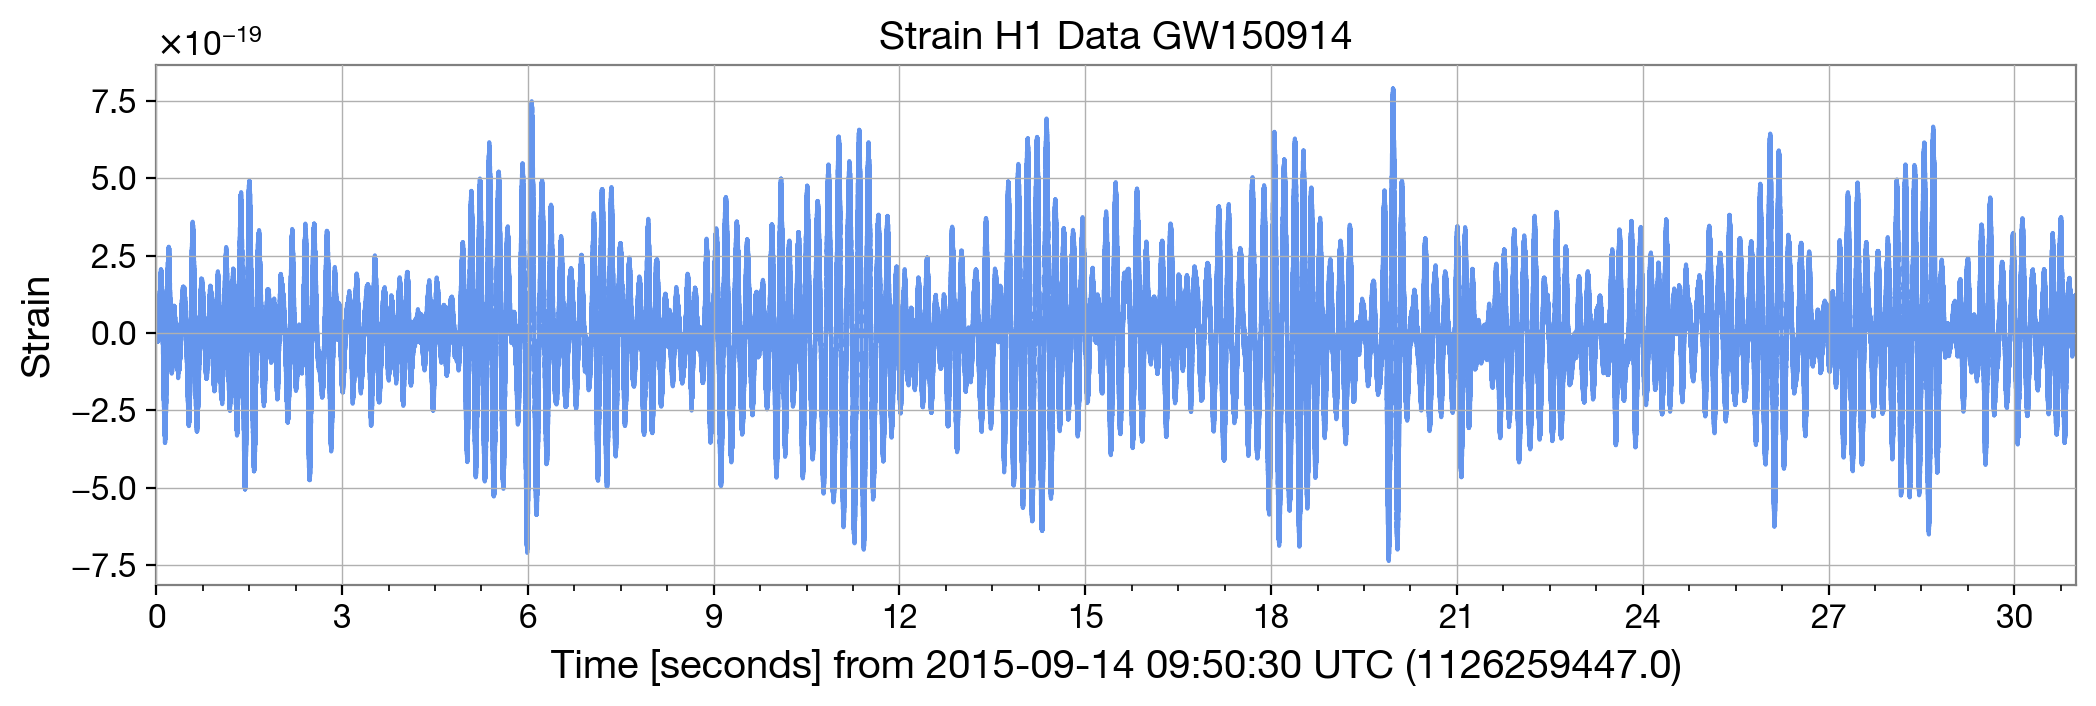

In [2]:

# -- Read strain data
#strain = TimeSeries.read(file_H1, format='hdf5.losc')
strain = TimeSeries.read('data/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5', format='hdf5.losc')
center = int(t0)
strain_H1 = strain.crop(center-16, center+16)
fig1 = strain_H1.plot(color='cornflowerblue')
plt.ylabel('Strain')
plt.title('Strain H1 Data GW150914')

plt.show()

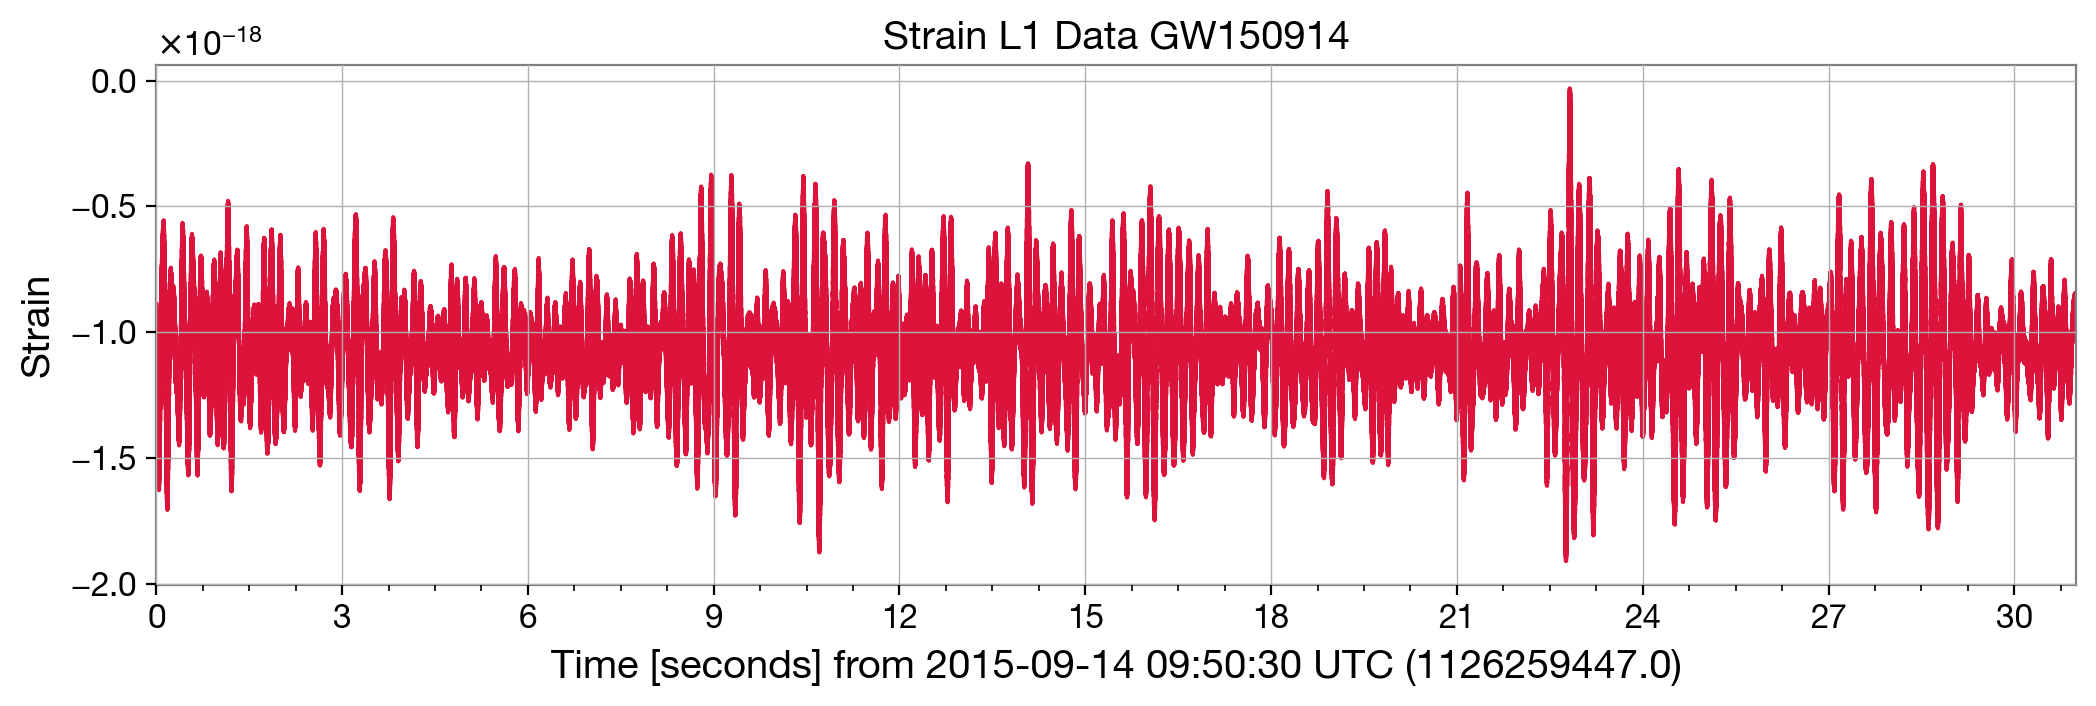

In [3]:
# -- Read strain data
#strain = TimeSeries.read(file_L1, format='hdf5.losc')
strain = TimeSeries.read('data/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5', format='hdf5.losc')
center = int(t0)
strain_L1 = strain.crop(center-16, center+16)

fig1 = strain_L1.plot(color='crimson')
plt.ylabel('Strain')
plt.title('Strain L1 Data GW150914')

plt.show()

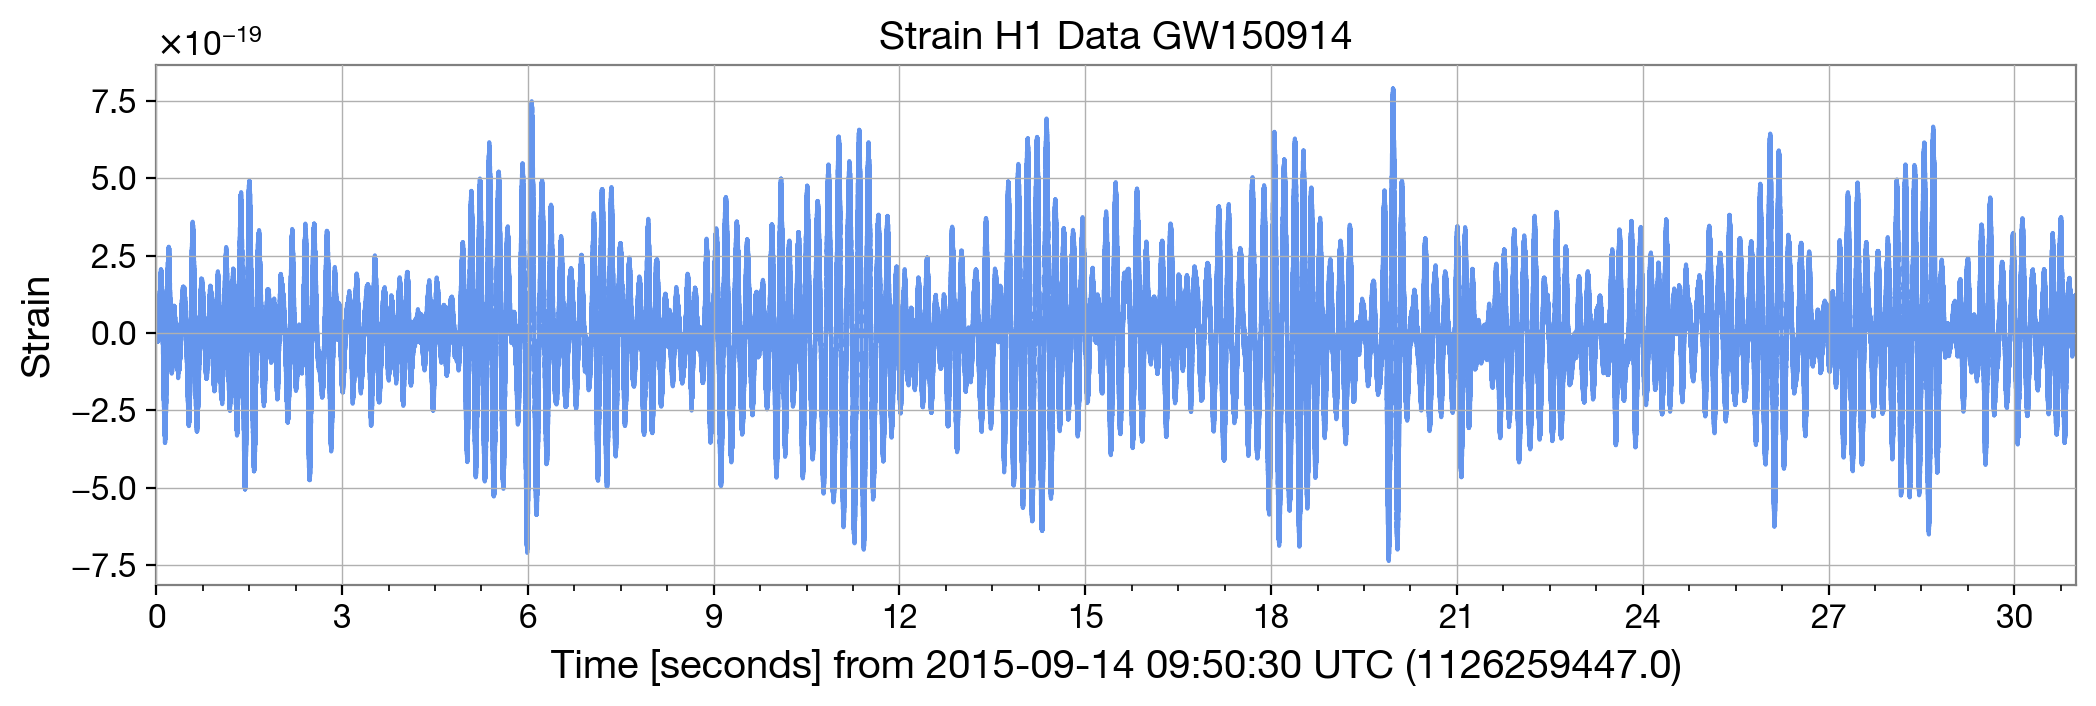

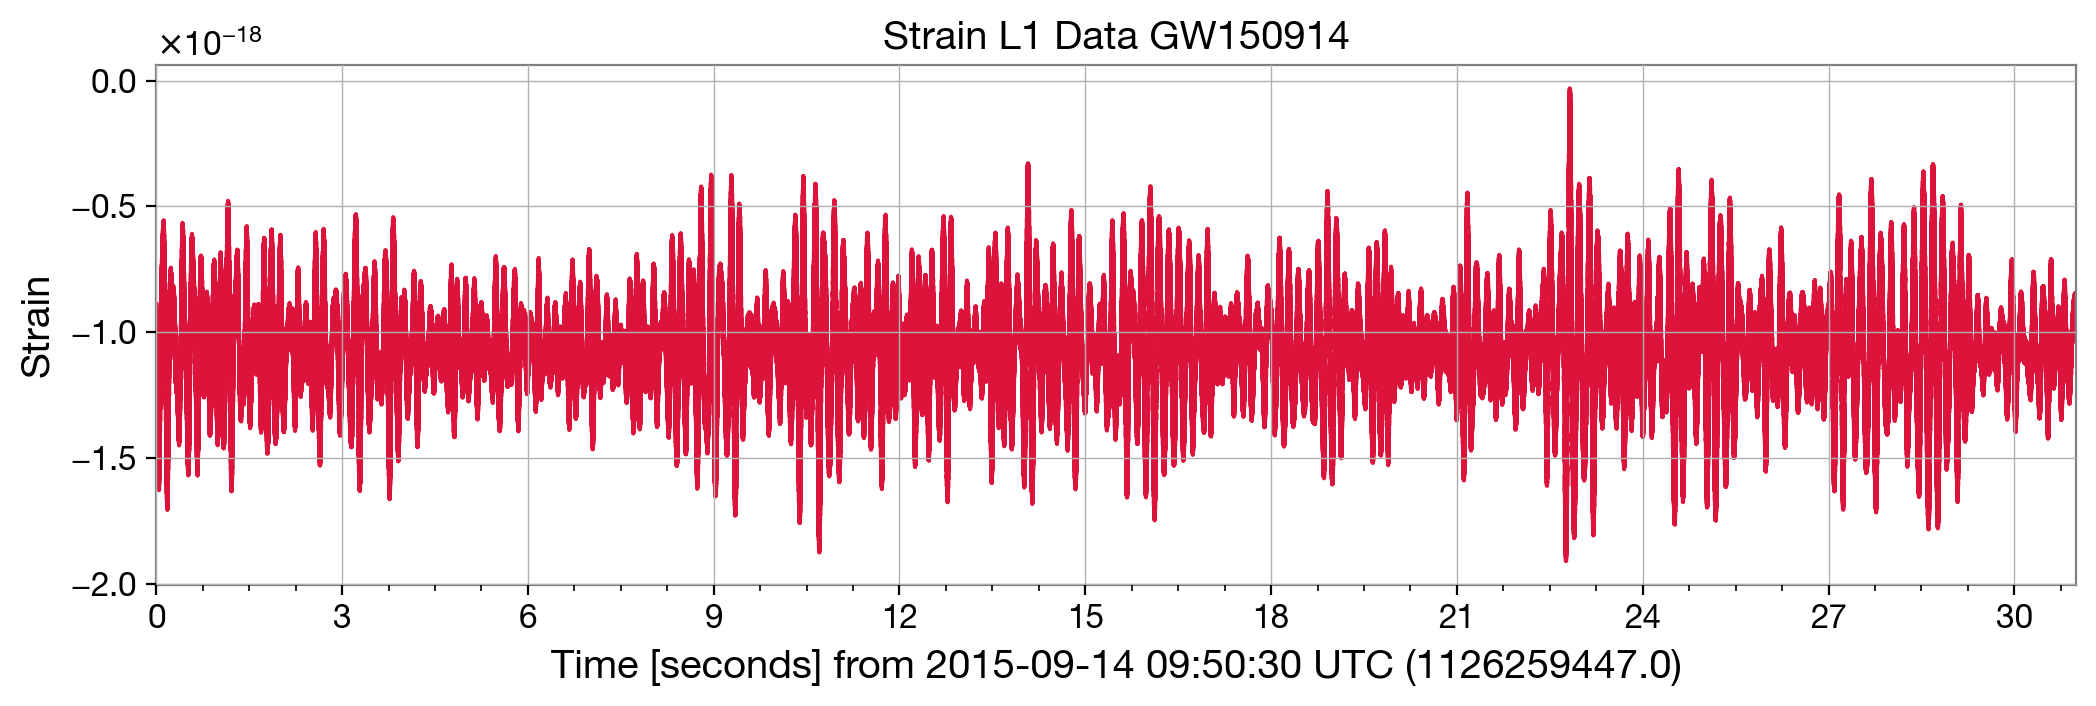

In [4]:
strain_H1.plot(color='cornflowerblue')
plt.ylabel('Strain')
plt.title('Strain H1 Data GW150914')

strain_L1.plot(color='crimson')
plt.ylabel('Strain')
plt.title('Strain L1 Data GW150914')
plt.show()

### Plot the Amplitude Spectral Density (ASD)

Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. 

A way to visualize the frequency content is to plot the **A**mplitude **S**pectral **D**ensity (**ASD**), i.e. the square root of the **P**ower **S**pectral **D**ensity (**PSD**), which is the average of the square of the **F**ast **F**ourier **T**ransform (FFT) of the data.

The ASD is an estimate of the "strain-equivalent noise" of the detectors versus frequency, which limit the ability of the detectors to identify GW signals. It is measured  in units of strain/rt(Hz). 

To obtain the root-mean-square strain noise in some frequency band,we must integrate the squares of the ASD over that band and then take the square-root.

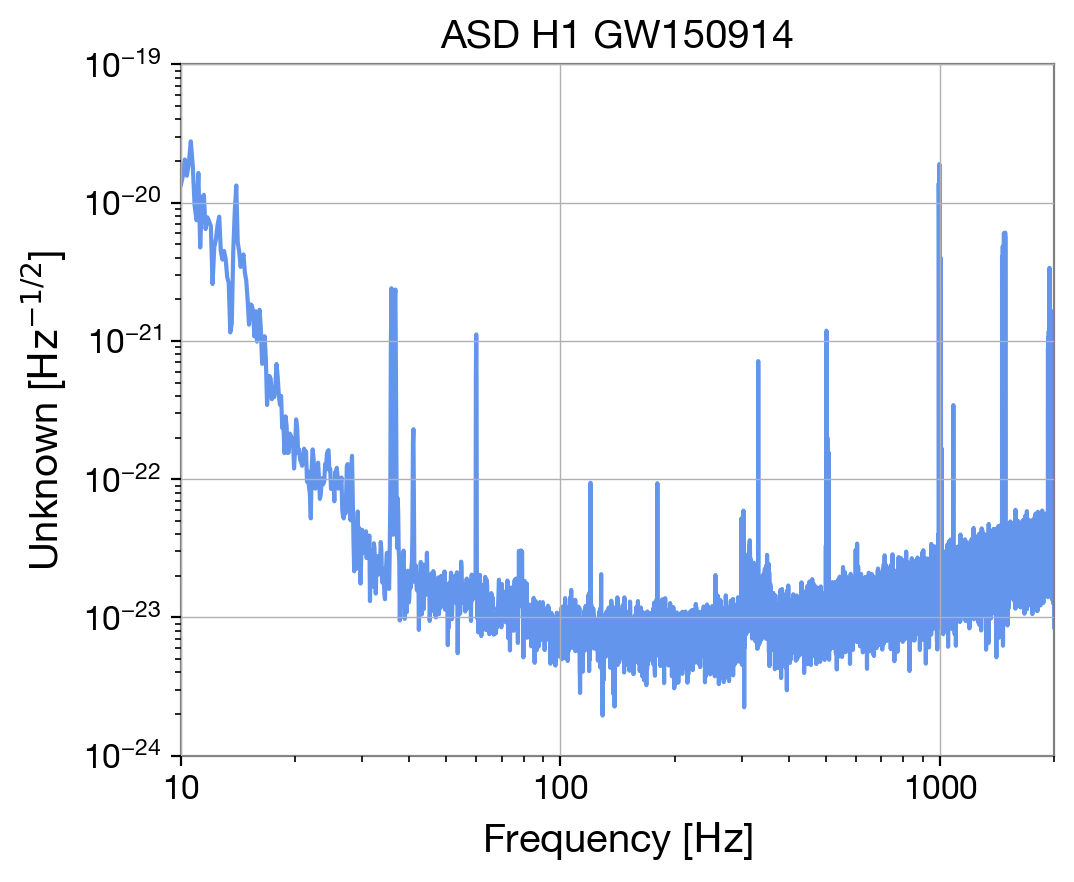

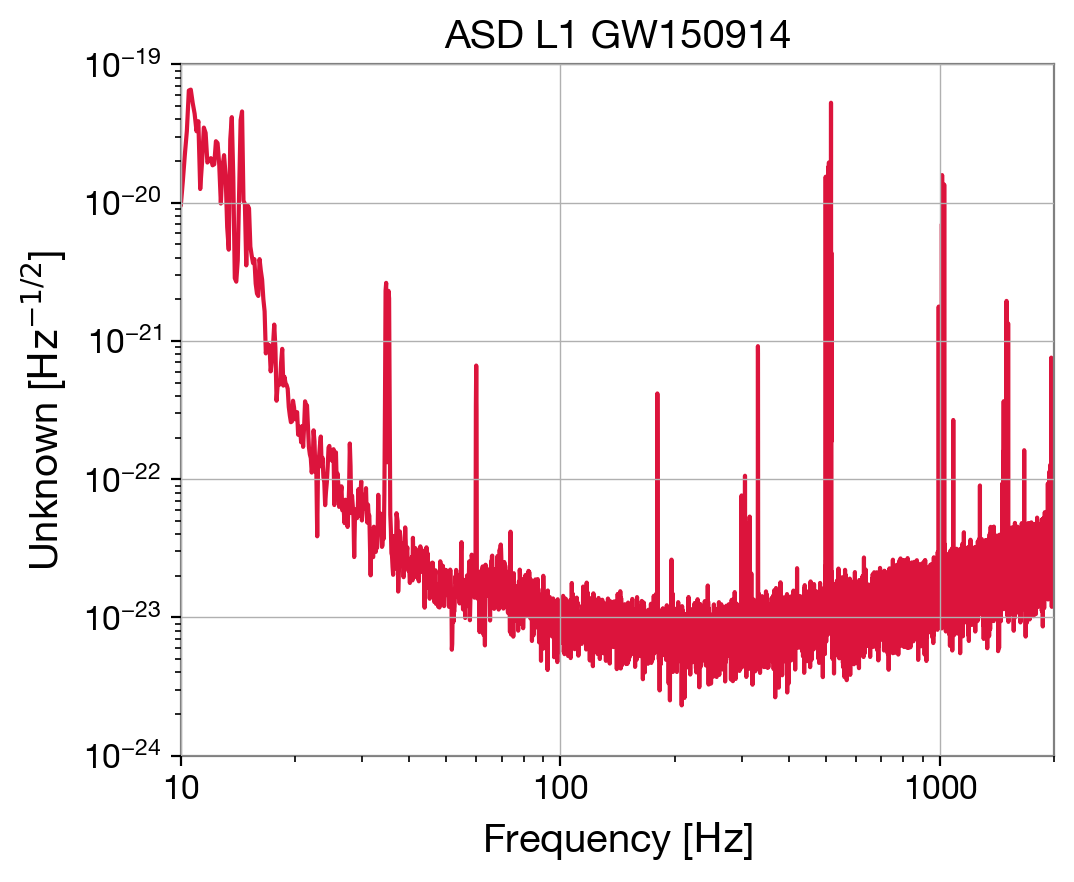

In [5]:
# -- Plot ASD

fig1 = strain_H1.asd(fftlength=8).plot(color='cornflowerblue')
plt.title('ASD H1 GW150914')
plt.xlim(10,2000)
plt.ylim(1e-24, 1e-19)


fig2 = strain_L1.asd(fftlength=8).plot(color='crimson')
plt.title('ASD L1 GW150914')
plt.xlim(10,2000)
plt.ylim(1e-24, 1e-19)
plt.show()

In these plots we only consider frequencies between $f_{min} = 20$ Hz and $f_{max} = 2000$ Hz.

Below $f_{min}$ the data are not properly calibrated (the noise is so high that LIGO cannot sense gravitational wave strain from astrophysical sources below this value). On the other hand, the sample rate of this event is $f_s = 4096$ Hz (i.e. $2^{12}$ Hz). Hence, the data cannot capture frequency content above the *Nyquist frequency*, defined as $f_N = \frac{fs}{2} = 2048$ Hz. 

From the plots, it is easy to see strong spectral lines in the data. These have an instrumental origin as for example that corresponding to the detectors, which are suspended mirrors with resonances at $~500$ Hz (and harmonics).

The ASD figure does not show the GW signal because it is relatively weak and less than a second long and the plot averages over 32 seconds. In fact, this plot is entirely dominated by instrumental noise.

### Whiten and band-pass the data


From the ASD plot above we can see that the noise fluctuations are much larger at low and high frequencies and near spectral lines. On the other hand,  the plot reaches a roughly flat (*white*) minimum in the band around $80$ to $300$ Hz.

Hence, we can "whiten" the data by dividing it by the noise amplitude spectrum (in the fourier domain). This will suppress the extra noise at low frequencies and at the spectral lines and the weak signals may be seen in the most sensitive band. This process of *whitening* is always one of the first steps in astrophysical data analysis and it requires no prior knowledge of spectral lines.

Aditionally, in order to get rid of remaining high frequency noise, we will also bandpass the data. The resulting time series will be no longer in units of strain but  in units of *sigmas* away from the mean.

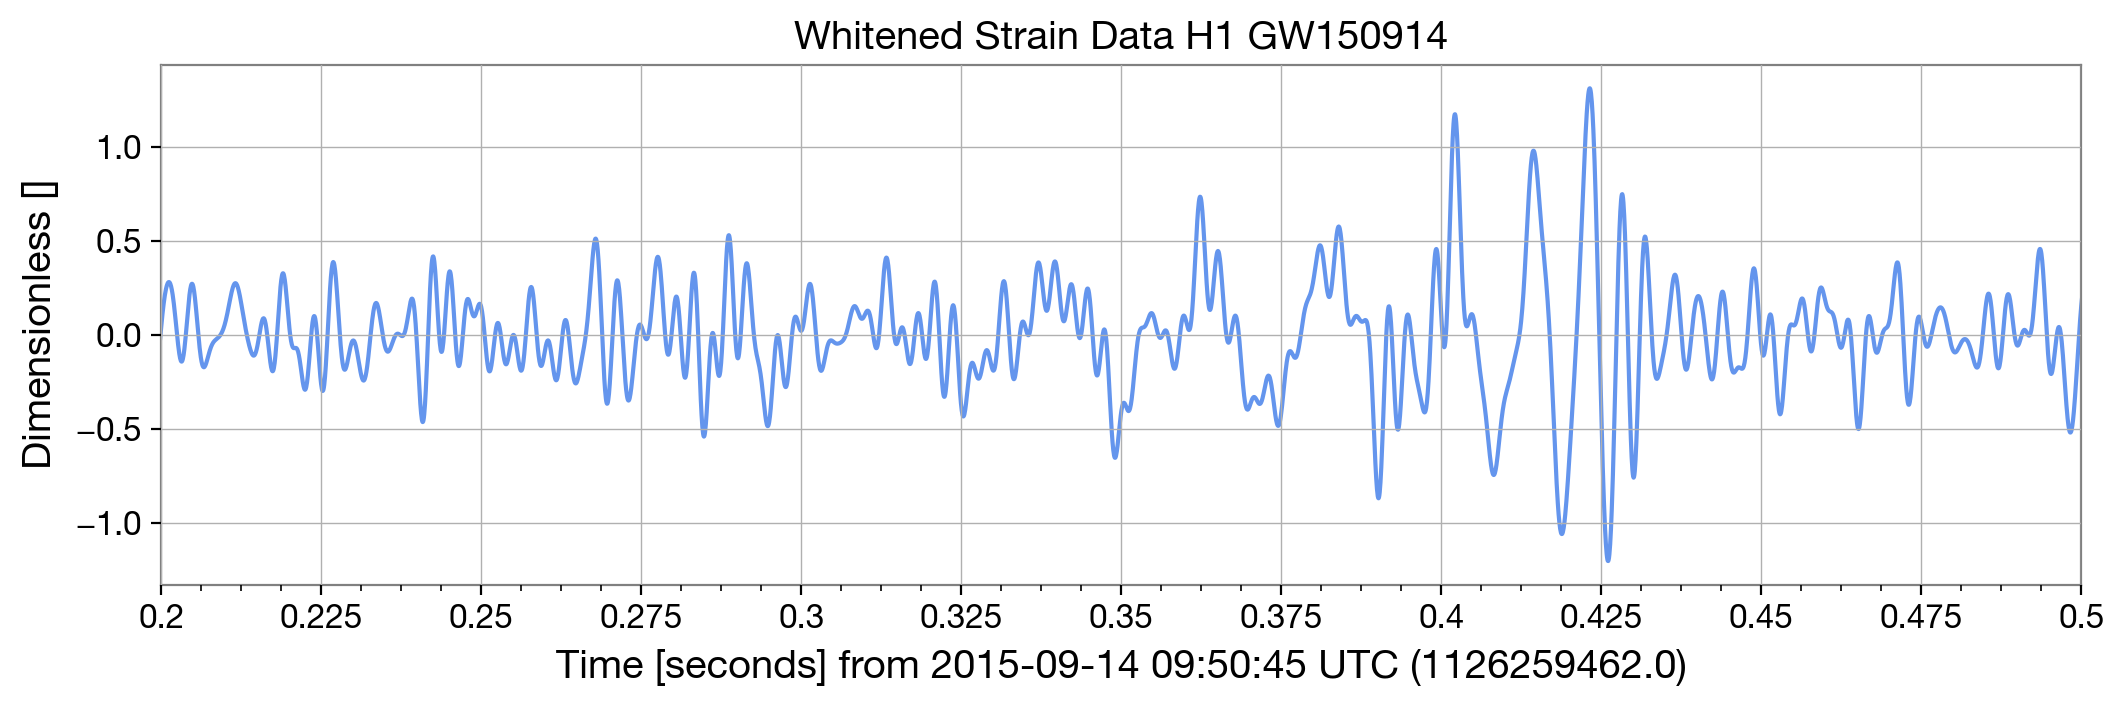

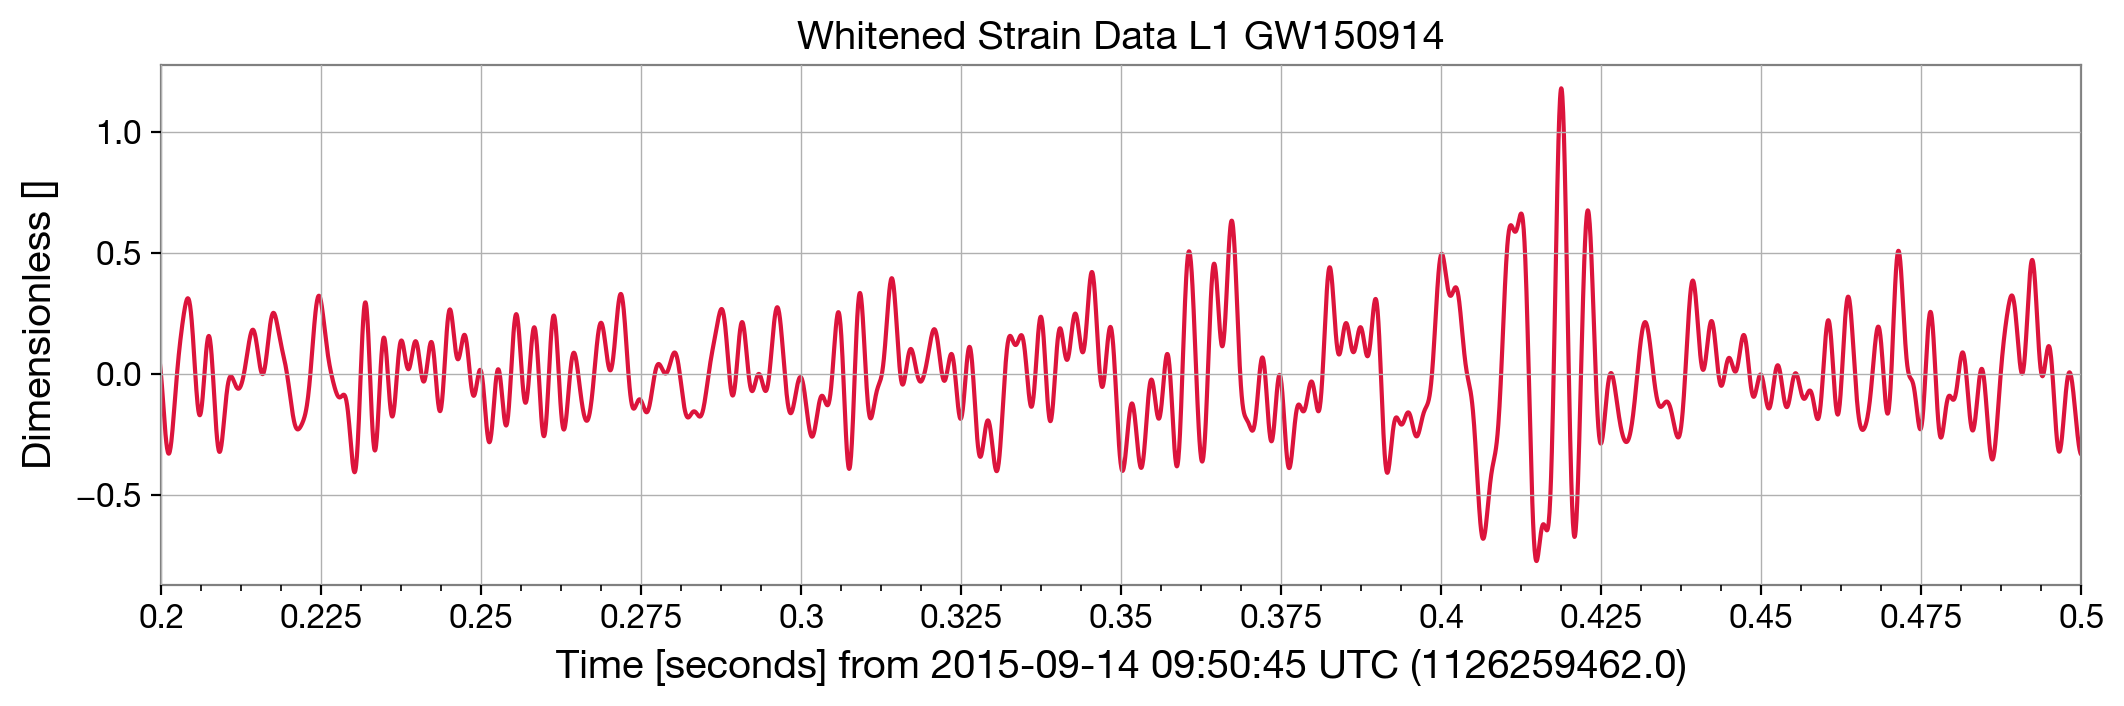

In [6]:
# -- Whiten and bandpass data
white_data_H1 = strain_H1.whiten()
bp_data_H1 = white_data_H1.bandpass(30, 400)
fig1 = bp_data_H1.plot(color='cornflowerblue')
plt.xlim(t0-0.2, t0+0.1)
plt.title('Whitened Strain Data H1 GW150914')

white_data_L1 = strain_L1.whiten()
bp_data_L1 = white_data_L1.bandpass(30, 400)
fig2 = bp_data_L1.plot(color='crimson')
plt.xlim(t0-0.2, t0+0.1)
plt.title('Whitened Strain Data L1 GW150914')

plt.show()

### Plot a q-transform of the data

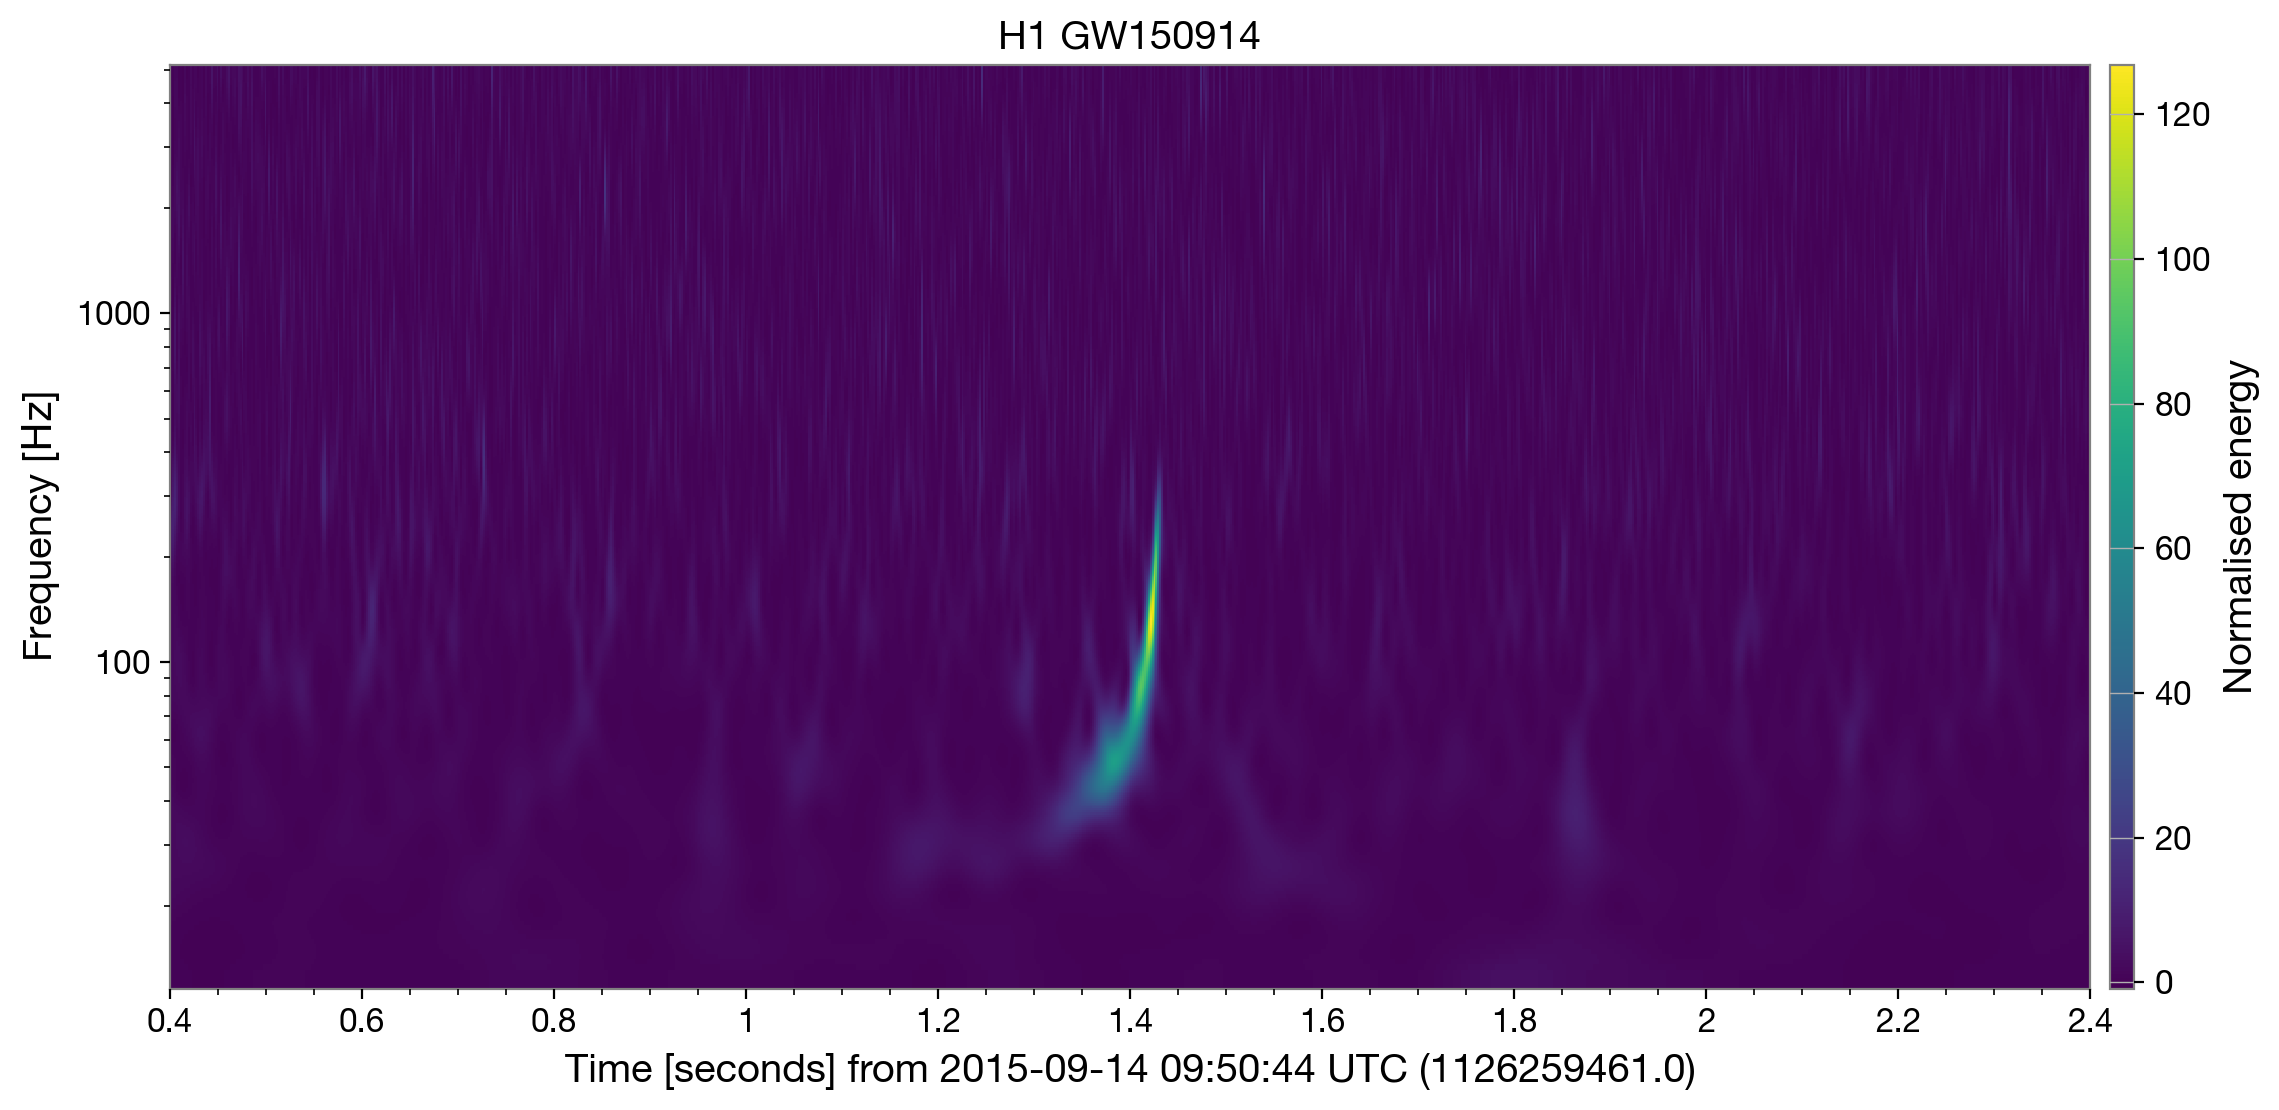

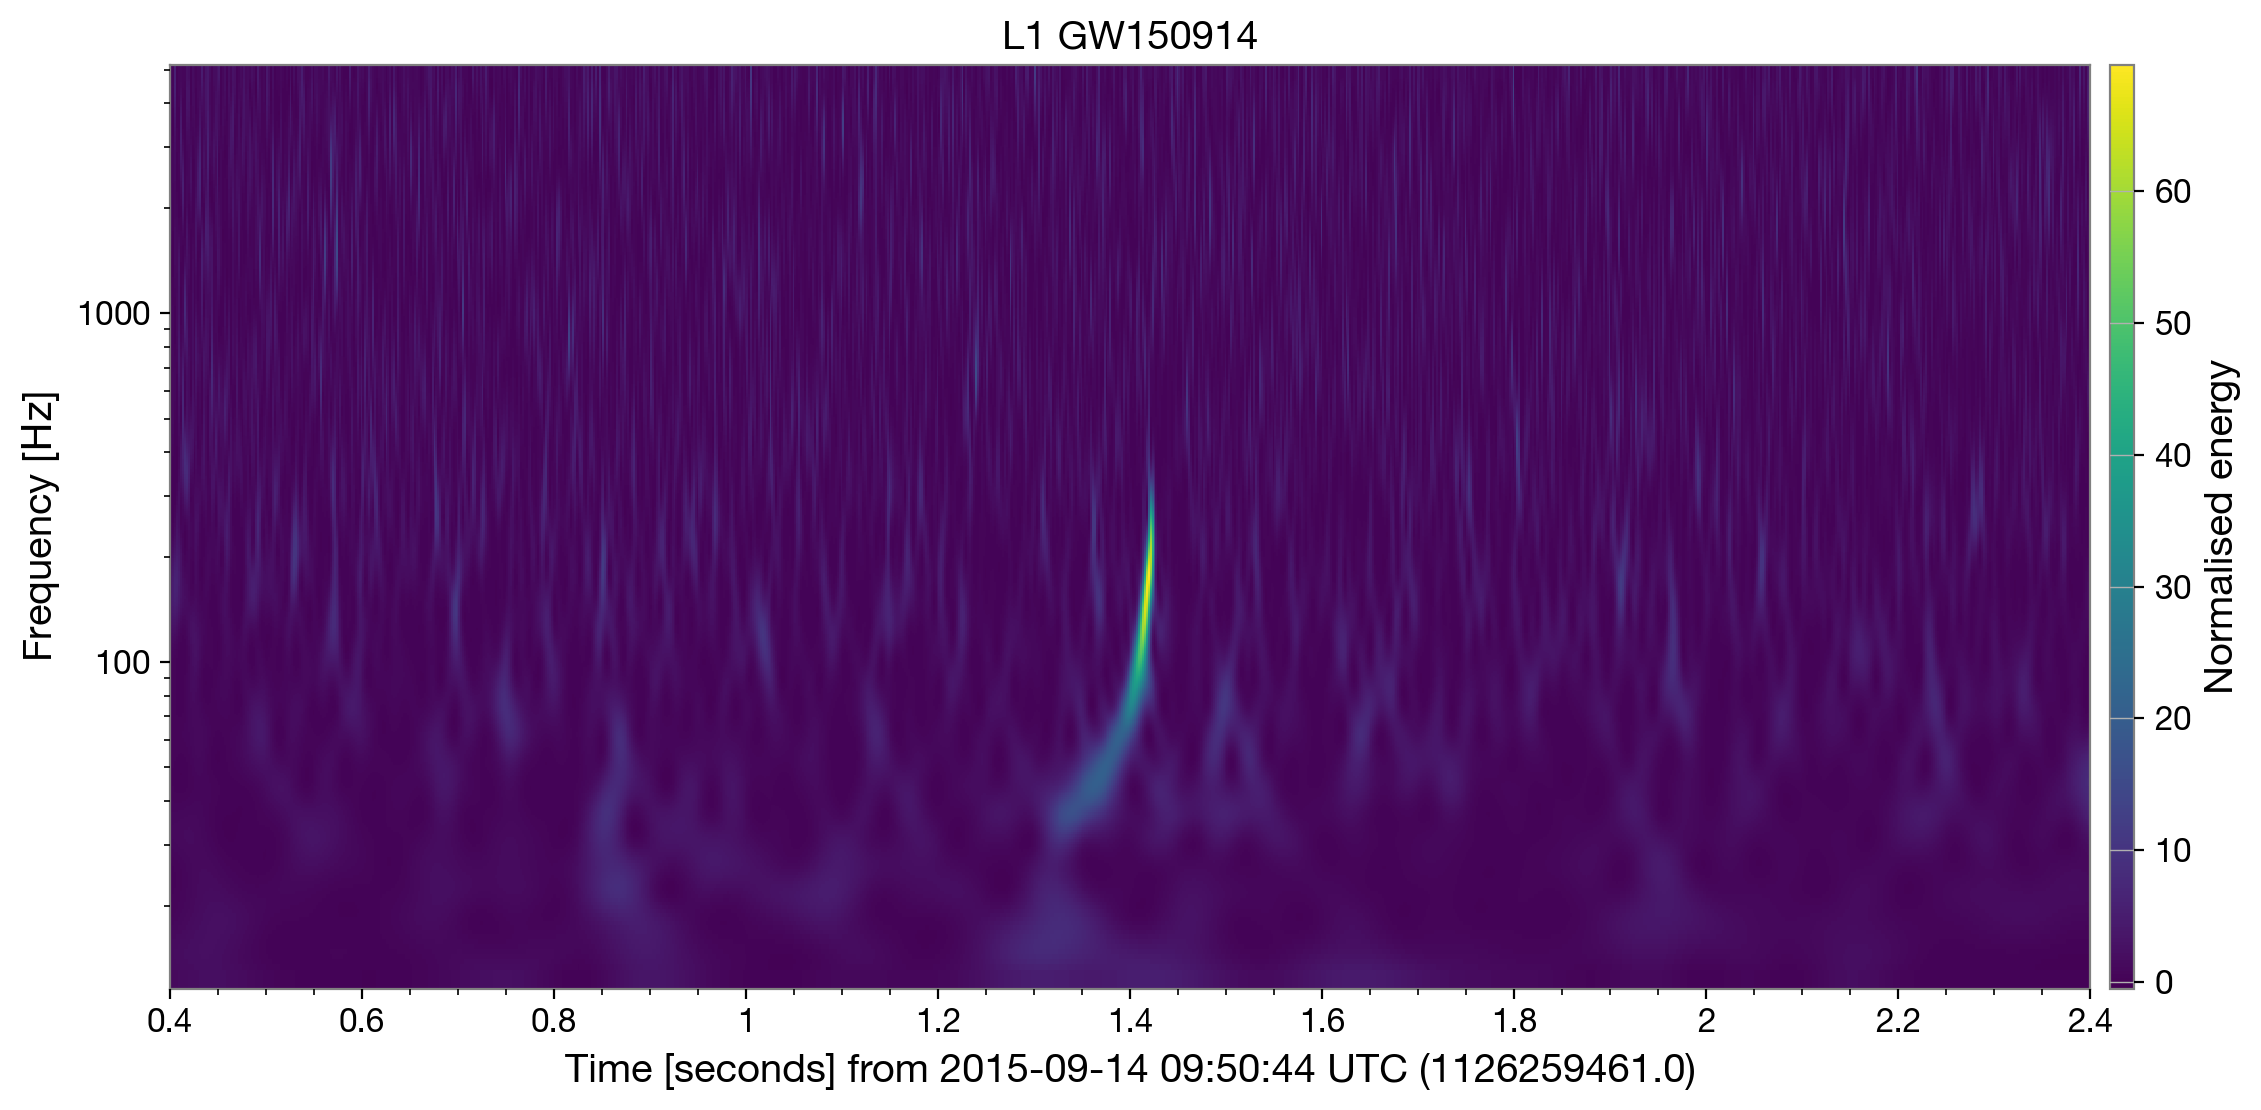

In [7]:
dt = 1  #-- Set width of q-transform plot, in seconds
hq_H1 = strain_H1.q_transform(outseg=(t0-dt, t0+dt))
fig1 = hq_H1.plot()
ax = fig1.gca()
fig1.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')
ax.set_title('H1 GW150914')


dt = 1  #-- Set width of q-transform plot, in seconds
hq_L1 = strain_L1.q_transform(outseg=(t0-dt, t0+dt))
fig2 = hq_L1.plot()
ax = fig2.gca()
fig2.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')
ax.set_title('L1 GW150914')

plt.show()

## Save the signal data as a .txt file

The processed signal `bp_data_H` is a TimeSeries object. Documentation about this kind of object is available at [https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#)

In [8]:
type(bp_data_H1)

gwpy.timeseries.timeseries.TimeSeries

The TimeSeries object has an attribute called `.times` which stores the time information of the signal.

In [9]:
bp_data_H1.times

<Index [1.12625945e+09, 1.12625945e+09, 1.12625945e+09, ...,
        1.12625948e+09, 1.12625948e+09, 1.12625948e+09] s>

Now, we will store the time information as well as the signal as arrays,

In [11]:
times_H1 = np.asarray(bp_data_H1.times)
times_H1

array([1.12625945e+09, 1.12625945e+09, 1.12625945e+09, ...,
       1.12625948e+09, 1.12625948e+09, 1.12625948e+09])

In [12]:
signal_H1 = np.asarray(bp_data_H1)
signal_H1

array([ 0.01946476,  0.02552168,  0.0316039 , ..., -0.00050601,
       -0.00054608, -0.00056685])

In order to extract the signal, we will find the index corresponding to the beginning time $t_0$,

In [26]:
t_idx = np.where(times_H1<t0 - 0.2)
t_idx

(array([     0,      1,      2, ..., 249034, 249035, 249036]),)

In [27]:
t0_idx = t_idx[-1][-1]
t0_idx

249036

We will also find the index corresponding to the final time of the signal,

In [28]:
t_idx = np.where(times_H1<t0 + 0.1)
tf_idx = t_idx[-1][-1]
tf_idx

253951

We can plot the extracted signal,

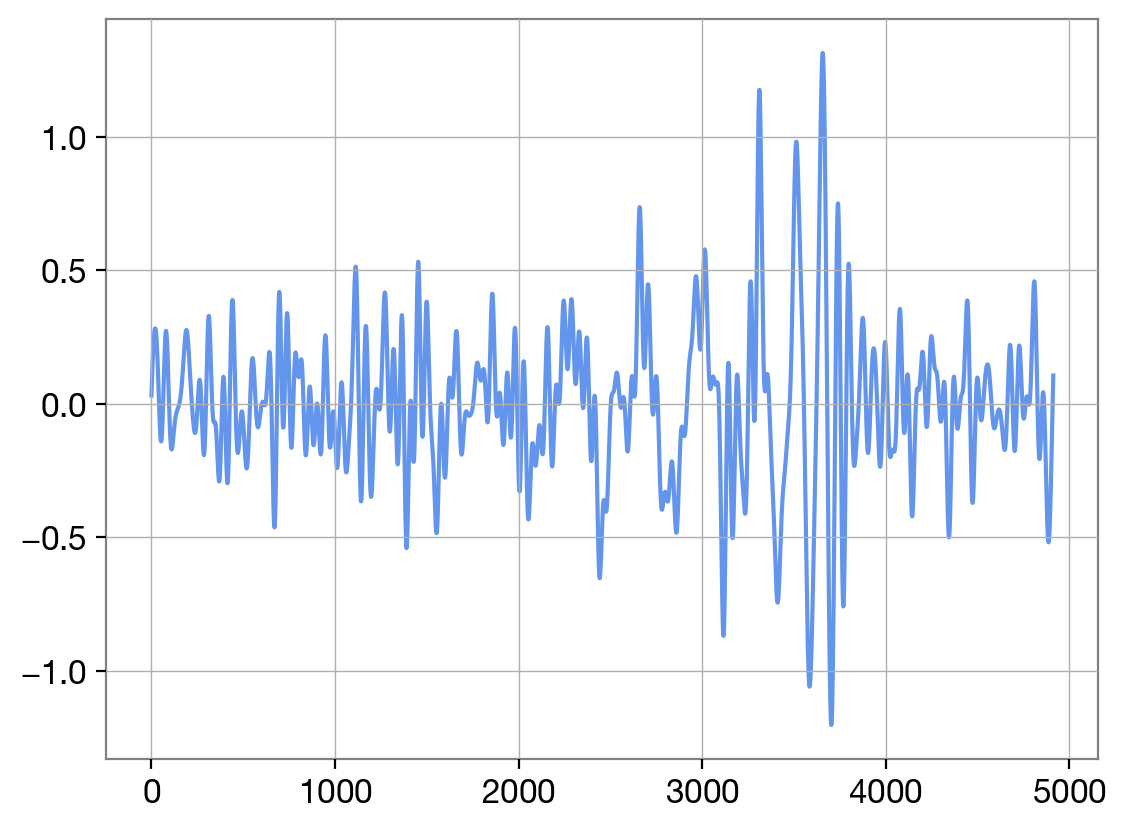

In [37]:
plt.figure()
plt.plot(signal_H1[t0_idx:tf_idx], color='cornflowerblue')
plt.show()

And we will save this siganl as a .txt file,

In [35]:
np.savetxt('signalH1.txt',signal_H1[t0_idx:tf_idx])

---
Now we extract and save the signal registered by the L1 detector following the same procedure,

In [36]:
times_L1 = np.asarray(bp_data_L1.times)
signal_L1 = np.asarray(bp_data_L1)
t_idx = np.where(times_L1<t0 - 0.2)
t0_idx = t_idx[-1][-1]

t_idx = np.where(times_L1<t0 + 0.1)
tf_idx = t_idx[-1][-1]

np.savetxt('signalL1.txt',signal_L1[t0_idx:tf_idx])

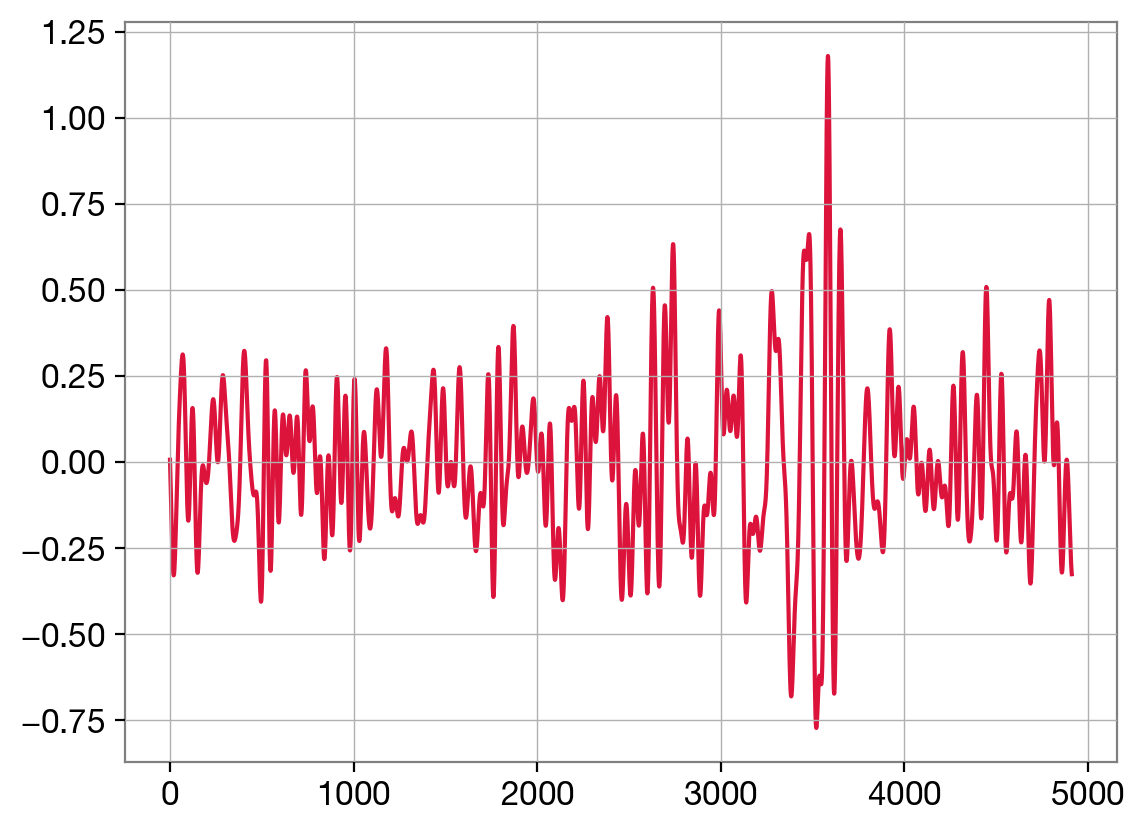

In [38]:
plt.figure()
plt.plot(signal_L1[t0_idx:tf_idx], color='crimson')
plt.show()

The size of the signals is

In [39]:
signal_L1[t0_idx:tf_idx].shape

(4915,)